In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.resampling import (
    add_normalized_timestamp,
)
from src.features.scaling import scale_min_max
from src.log_config import configure_logging
from src.models.data_loader import transform_sample_df_to_arrays
from src.models.sample_creation import create_samples, make_sample_set_balanced
from src.plots.utils import prepare_multiline_hvplot

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

db = DatabaseManager()

In [ ]:
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

intervals = {
    "increases": "strictly_increasing_intervals",
    "decreases": "major_decreasing_intervals",
}
label_mapping = {
    "increases": 0,
    "decreases": 1,
}
offsets_ms = {
    "increases": 0,
    "decreases": 2000,
}

sample_duration_ms = 3000
samples = create_samples(
    df,
    intervals,
    label_mapping,
    sample_duration_ms,
    offsets_ms,
)
samples = samples.select(
    "sample_id",
    "trial_id",
    "participant_id",
    "normalized_timestamp",
    "timestamp",
    "rating",
    "temperature",
    "eda_raw",
    "eda_tonic",
    "eda_phasic",
    "pupil",
    "cheek_raise",
    "label",
)
samples


19:12:59 | DEBUG   | sample_creation | Removed 80 samples with less than 29 data points


sample_id,trial_id,participant_id,normalized_timestamp,timestamp,rating,temperature,eda_raw,eda_tonic,eda_phasic,pupil_mean,cheek_raise,label
u16,u16,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8
1,1,1,24300.0,318498.9762,0.7325,0.463265,0.743605,0.743493,0.000113,4.87651,0.000514,0
1,1,1,24400.0,318598.9762,0.7325,0.467223,0.743493,0.743497,-0.000004,4.863735,0.000497,0
1,1,1,24500.0,318698.9762,0.7325,0.474557,0.743368,0.743503,-0.000135,4.846388,0.00048,0
1,1,1,24600.0,318798.9762,0.7325,0.481841,0.743551,0.743508,0.000044,4.831943,0.000462,0
1,1,1,24700.0,318898.9762,0.7325,0.489092,0.743676,0.743512,0.000163,4.790776,0.000445,0
1,1,1,24800.0,318998.9762,0.7325,0.496241,0.743597,0.743517,0.00008,4.713818,0.000425,0
…,…,…,…,…,…,…,…,…,…,…,…,…
4128,516,50,164400.0,2.6805e6,1.0,0.849148,27.118041,27.164955,-0.047986,5.547838,0.001395,1
4128,516,50,164500.0,2.6806e6,1.0,0.844366,27.111615,27.158746,-0.048233,5.554787,0.001397,1


In [5]:
samples.group_by("sample_id").len("count")

sample_id,count
u16,u32
1,30
2,30
3,30
4,30
5,30
6,30
…,…
4123,30
4124,30


In [6]:
samples = make_sample_set_balanced(samples)

sample_ids = (
    samples.group_by("sample_id").agg(pl.all().first()).select("sample_id", "label")
)
sample_ids_count = sample_ids.get_column("label").value_counts()
sample_ids_count

label,count
u8,u32
1,1413
0,1413


In [7]:
df.hvplot(
    x="normalized_timestamp", y="temperature", groupby="trial_id", height=300
) * samples.hvplot(
    x="normalized_timestamp",
    y="temperature",
    groupby="trial_id",
    height=300,
    kind="scatter",
    color="red",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f9206390-3128-43d5-b1f0-2bdc8c700d5b': {'version…

In [ ]:
samples

In [ ]:
X, y, groups = transform_sample_df_to_arrays(
    (samples),
    [
        "temperature",  # only for visualization
        # "rating",
        # "eda_raw",
        # "eda_raw",
        "cheek_raise",
        # "pupil",
    ],
)


@ipywidgets.interact(sample=(0, X.shape[0] - 1))
def plot_sample(sample):
    # note that sample != sample id
    for i in range(X.shape[2]):
        plt.plot(X[sample, :, i])
    # plt.ylim(0, 1.05)

interactive(children=(IntSlider(value=1412, description='sample', max=2825), Output()), _dom_classes=('widget-…

In [26]:
X.shape

(2826, 30, 2)

In [ ]:
prepare_multiline_hvplot(
    add_normalized_timestamp(
        (samples),
        time_column="normalized_timestamp",
        trial_column="sample_id",
    ),
    time_column="normalized_timestamp",
    trial_column="sample_id",
).hvplot(
    x="normalized_timestamp",
    y=[
        # "rating",
        "eda_raw",
        "temperature",
    ],
    groupby="label",
    height=300,
    ylim=(0, 1.05),
    color=["blue", "orange"],
)

In [4]:
import argparse
import logging
from datetime import datetime
from pathlib import Path

import optuna.logging

from src.data.database_manager import DatabaseManager
from src.features.labels import add_labels
from src.features.resampling import add_normalized_timestamp
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import (
    BATCH_SIZE,
    INTERVALS,
    LABEL_MAPPING,
    N_EPOCHS,
    N_TRIALS,
    OFFSETS_MS,
    RANDOM_SEED,
    SAMPLE_DURATION_MS,
)
from src.models.model_selection import (
    ExperimentTracker,
    run_model_selection,
    train_evaluate_and_save_best_model,
)
from src.models.models_config import MODELS
from src.models.utils import get_device, set_seed


In [6]:
import logging
from pathlib import Path

from src.data.database_manager import DatabaseManager
from src.features.resampling import add_normalized_timestamp
from src.log_config import configure_logging
from src.models.sample_creation import create_samples, make_sample_set_balanced

configure_logging(stream_level=logging.DEBUG)

eeg_features = ["f3", "f4", "c3", "c4", "cz", "p3", "p4", "oz"]
features = eeg_features
# Load data from database
db = DatabaseManager()
with db:
    eeg = db.get_table(
        "Preprocess_EEG",
        exclude_trials_with_measurement_problems=True,
    )
    trials = db.get_table(
        "Trials",
        exclude_trials_with_measurement_problems=True,
    )
    eeg = add_normalized_timestamp(eeg)
    df = add_labels(eeg, trials)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
intervals = {
    "increases": "strictly_increasing_intervals",
    "decreases": "major_decreasing_intervals",
}
label_mapping = {
    "increases": 0,
    "decreases": 1,
}
offsets_ms = {
    "increases": 0,
    "decreases": 2000,
}

sample_duration_ms = 7000

# Create and balance samples
samples = create_samples(df, intervals, label_mapping, sample_duration_ms, offsets_ms)
samples = make_sample_set_balanced(samples, 1337)

print(samples.filter(sample_id=3768))


18:43:12 | WARNING | sample_creation | Sampling rate is not equidistant with 10 Hz.
shape: (5_283_250, 27)
┌──────────┬────────────┬────────────┬───────────┬───┬────────────┬────────────┬───────┬───────────┐
│ trial_id ┆ trial_numb ┆ participan ┆ rownumber ┆ … ┆ normalized ┆ normalized ┆ label ┆ sample_id │
│ ---      ┆ er         ┆ t_id       ┆ ---       ┆   ┆ _timestamp ┆ _timestamp ┆ ---   ┆ ---       │
│ u16      ┆ ---        ┆ ---        ┆ u32       ┆   ┆ _increases ┆ _decreases ┆ u8    ┆ u16       │
│          ┆ u8         ┆ u8         ┆           ┆   ┆ ---        ┆ ---        ┆       ┆           │
│          ┆            ┆            ┆           ┆   ┆ f64        ┆ f64        ┆       ┆           │
╞══════════╪════════════╪════════════╪═══════════╪═══╪════════════╪════════════╪═══════╪═══════════╡
│ 1        ┆ 1          ┆ 1          ┆ 159236    ┆ … ┆ 0.0        ┆ null       ┆ 0     ┆ 1         │
│ 1        ┆ 1          ┆ 1          ┆ 159238    ┆ … ┆ 4.0001     ┆ null       ┆ 0   

In [8]:
samples

trial_id,trial_number,participant_id,rownumber,timestamp,f3,f4,c3,cz,c4,p3,p4,oz,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals,normalized_timestamp_increases,normalized_timestamp_decreases,label,sample_id
u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16,f64,f64,u8,u16
1,1,1,159236,318499.4498,4.864119,6.288388,6.12215,7.617009,7.544454,6.332759,2.572159,1.177451,24300.987,396,1,0,0,1,1,0,0,0,0.0,null,0,1
1,1,1,159238,318503.4499,12.33133,4.563441,9.251234,7.63424,2.469335,5.120281,-1.464273,0.130467,24304.9871,396,1,0,0,1,1,0,0,0,4.0001,null,0,1
1,1,1,159240,318507.3066,7.243493,5.995082,1.865997,6.598088,0.74527,2.344545,-2.692952,-0.893515,24308.8438,396,1,0,0,1,1,0,0,0,7.8568,null,0,1
1,1,1,159242,318511.5252,4.938367,12.478059,4.753045,11.44356,7.446143,5.917428,2.644361,4.426261,24313.0624,396,1,0,0,1,1,0,0,0,12.0754,null,0,1
1,1,1,159244,318515.4867,2.298745,4.902164,-0.454101,6.82498,-0.399314,-0.744325,-4.293437,-3.743488,24317.0239,396,1,0,0,1,1,0,0,0,16.0369,null,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
516,12,50,1342488,2.6851e6,-1.54988,4.180207,-1.171553,-5.029435,-3.385484,-1.16904,-8.909362,-9.70915,168981.0189,806,1,2355,1413,0,0,0,0,0,null,8980.1709,1,3768
516,12,50,1342490,2.6851e6,5.92358,-7.01102,-4.775418,-7.329566,-7.794008,-5.560546,-12.779723,-11.90354,168984.9334,806,1,2355,1413,0,0,0,0,0,null,8984.0854,1,3768
516,12,50,1342492,2.6851e6,18.902786,11.090164,4.968312,3.933333,5.664877,2.039669,-1.778671,-6.392546,168988.7518,806,1,2355,1413,0,0,0,0,0,null,8987.9038,1,3768


In [ ]:
X, y, groups = transform_sample_df_to_arrays(
    (samples),
    [
        "f3",
        "f4",
        "c3",
        # "temperature",  # only for visualization
        # "rating",
        # "eda_raw",
        # "eda_raw",
        # "pupil",
    ],
)


@ipywidgets.interact(sample=(0, X.shape[0] - 1))
def plot_sample(sample):
    # note that sample != sample id
    for i in range(X.shape[2]):
        plt.plot(X[sample, :, i])
    # plt.ylim(0, 1.05)

interactive(children=(IntSlider(value=1292, description='sample', max=2585), Output()), _dom_classes=('widget-…

In [14]:
df

trial_id,trial_number,participant_id,rownumber,timestamp,f3,f4,c3,cz,c4,p3,p4,oz,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,147086,294198.4628,-1.5150e-12,1.6438e-12,1.9829e-12,2.2742e-12,1.5041e-12,1.5858e-12,5.2300e-12,1.3767e-14,0.0,396,1,0,0,1,0,0,0,0
1,1,1,147088,294202.5715,12.280578,15.555687,-13.694891,-7.270244,6.838309,-7.189818,-7.400425,-3.066208,4.1087,396,1,0,0,1,0,0,0,0
1,1,1,147090,294206.6215,45.497951,38.992184,-6.325961,-4.11582,22.614502,-7.301916,-11.448706,-5.534098,8.1587,396,1,0,0,1,0,0,0,0
1,1,1,147092,294210.5259,40.068399,35.789636,-20.612573,-10.737569,15.988759,-16.391113,-19.374253,-12.964259,12.0631,396,1,0,0,1,0,0,0,0
1,1,1,147094,294214.3388,11.701849,13.669035,-6.561412,-5.952719,4.902351,-6.972598,-8.792239,-5.146666,15.876,396,1,0,0,1,0,0,0,0
1,1,1,147096,294218.4235,6.53695,9.415504,2.014552,3.038253,6.160784,-0.709822,1.421809,1.055935,19.9607,396,1,0,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
516,12,50,1348000,2.6961e6,-54.799495,-63.96125,-64.616702,-64.723998,-70.628028,-70.927058,-78.414296,-75.352529,180004.6706,806,1,0,0,0,0,0,0,0
516,12,50,1348002,2.6961e6,6.490642,3.091599,-3.967783,2.572031,-2.170522,-9.43316,-7.011082,-36.066678,180008.9498,806,1,0,0,0,0,0,0,0


In [15]:
# Load data from database
db = DatabaseManager()
with db:
    eeg = db.get_table(
        "raw_EEG",
        exclude_trials_with_measurement_problems=True,
    )
    trials = db.get_table(
        "Trials",
        exclude_trials_with_measurement_problems=True,
    )
    eeg = add_normalized_timestamp(eeg)
    df_raw = add_labels(eeg, trials)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

signal = torch.randn(1280, 1, 22, 200)
label = torch.randint(2, (1280,))

train_batch_size = 256

dataset = TensorDataset(signal, label)

data_loader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

print("train batch size:", data_loader.batch_size, ", num of batch:", len(data_loader))


train batch size: 256 , num of batch: 5


In [6]:
signal.shape

torch.Size([1280, 1, 22, 200])

In [ ]:
import torch

from src.models.architectures.EEGNet import EEGNet

num_class = 2  # Number of classes in the dataset

model = EEGNet(
    input_len=200,
    num_channels=22,
    fs=200,
    dropout=0.5,
    num_class=num_class,
)

TypeError: EEGNet.__init__() got an unexpected keyword argument 'num_class'

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy


In [16]:
def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes=num_class).to(device)

    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())

    return model, loss_train.avg, acc_train.compute().item()


In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [19]:
num_epochs = 101
device = "cpu"
loss_fn = nn.CrossEntropyLoss().to("cpu")
optimizer = optim.NAdam(model.parameters(), lr=0.01)

loss_train_hist = []
acc_train_hist = []


for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(
        model, data_loader, loss_fn, optimizer
    )

    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch % 10 == 5) or (epoch % 10 == 0):
        print(f"epoch {epoch}:")
        print(f" Loss= {loss_train:.4}, Accuracy= {int(acc_train * 100)}% \n")


epoch 0:
 Loss= 0.6987, Accuracy= 50% 

epoch 5:
 Loss= 0.6778, Accuracy= 57% 

epoch 10:
 Loss= 0.6535, Accuracy= 61% 

epoch 15:
 Loss= 0.6189, Accuracy= 66% 

epoch 20:
 Loss= 0.5922, Accuracy= 71% 

epoch 25:
 Loss= 0.5659, Accuracy= 73% 

epoch 30:
 Loss= 0.5437, Accuracy= 75% 

epoch 35:
 Loss= 0.5317, Accuracy= 76% 

epoch 40:
 Loss= 0.5181, Accuracy= 78% 

epoch 45:
 Loss= 0.504, Accuracy= 80% 

epoch 50:
 Loss= 0.5066, Accuracy= 79% 

epoch 55:
 Loss= 0.489, Accuracy= 81% 

epoch 60:
 Loss= 0.475, Accuracy= 83% 

epoch 65:
 Loss= 0.4741, Accuracy= 83% 

epoch 70:
 Loss= 0.4596, Accuracy= 85% 

epoch 75:
 Loss= 0.4721, Accuracy= 82% 

epoch 80:
 Loss= 0.4618, Accuracy= 84% 

epoch 85:
 Loss= 0.4521, Accuracy= 85% 

epoch 90:
 Loss= 0.4624, Accuracy= 85% 

epoch 95:
 Loss= 0.4475, Accuracy= 86% 

epoch 100:
 Loss= 0.4554, Accuracy= 84% 



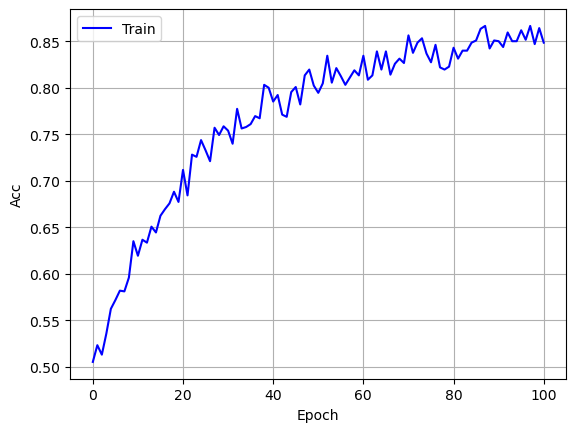

In [20]:
plt.plot(range(num_epochs), acc_train_hist, "b-", label="Train")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.grid(True)
plt.legend()
